# Recursive QAOA

In this notebook, we provide a short introduction to recursive QAOA, and demonstrate how this technique is implemented as an OpenQAOA Job, by solving a standard well-known problem from combinatorial optimization: the Minimum Vertex Cover

### A brief Introduction to RQAOA

Recursive QAOA (RQAOA) is an iterative variant of QAOA, first introduced by Bravyi et. al in [1] and further explored in [2,3]. 

This technique consists in recursively reducing the size of the problem by running QAOA. At each step, the QAOA output distribution is used to compute the expectation values 

$$
\mathcal{M}_{i} = \langle Z_{i} \rangle \qquad \qquad \qquad \qquad \qquad \mathcal{M}_{ij} = \langle Z_{i}Z_{j} \rangle,
$$

associated with the terms present in the Hamiltonian. Note that, by definition, these quantities are bounded between -1 and 1. The expectation values are then ranked according to their magnitude $|\mathcal{M}_{(i,ij)}|$. In its original formulation, the highest ranked value is selected. This value is then utilized to eliminate a qubit from the Hamiltonian. This is done by first, performing integer rounding of the expectation value, i.e. $\mathcal{M}_{(i,ij)} \rightarrow \textrm{sign}(\mathcal{M}_{(i,ij)})$, then transforming the rounded value into a constraint on the respective\ qubits

$$
Z_{i} \rightarrow \textrm{sign}(\mathcal{M}_{(i)}) \qquad \qquad \qquad \qquad \qquad \langle Z_{i} Z_{j} \rangle \rightarrow \textrm{sign}(\mathcal{M}_{(ij)}),
$$

and last, inserting the constraint into the Hamiltonian, effectively reducing the size of the problem by one qubit. Using the reduced Hamiltonian, QAOA is run again and the same procedure is followed. Once the reduced problem reaches a predefined cutoff size, it is solved exactly solved via classical methods. The final answer is then reconstructed by re-inserting the eliminated qubits into the classical solution following the appropriate order.

This version of RQAOA is included in OpenQAOA. Additionally, OpenQAOA features a modification of RQAOA which enable multiple qubit eliminations during the recursive process.

In [1]:
# All the required imports
import os
import networkx as nx
from datetime import datetime
from braket.aws import AwsQuantumJob
from braket.jobs.config import OutputDataConfig
import matplotlib.pyplot as plt

from openqaoa.workflows.optimizer import RQAOA
from openqaoa.workflows.aws_input.helpers import create_aws_input_data, save_input_data
from openqaoa.problems.problem import MinimumVertexCover
from openqaoa.problems.problem import QUBO
from openqaoa.utilities import plot_graph

## Problem: Minimum Vertex Cover of an N = 10 ring

We generate an instance of the Minimum Vertex Cover problem for a ring graph of 10 nodes, making use of the problem library in OpenQAOA.

As a brief reminder, the Minimum Vertex Cover problem consists in finding the minimum set of nodes in a graph such every edge in the graph is incident in at least one node in the set. For a ring, the answer corresponds to selecting all the even or all the odd nodes (i.e. an antiferromagnet!), meaning that the answer is doubly degenerate. Explicitly, the solutions reads `1010101010` and `0101010101`, and the ground state energy is $E_{gs} = 5$. If you are curious about the specific QUBO formulation of Minimum Vertex Cover, you can check out [3] (it also contains the QUBO form of many other interesting combinatorial optimization problems!)

In [2]:
# Number of qubits
n_qubits = 10

# Ring graph
G = nx.circulant_graph(n_qubits,[1])

# Minimum vertex cover parameters
field = 1.0
penalty = 10

# Define problem instance
vc = MinimumVertexCover(G,field = field,penalty = penalty).get_qubo_problem()

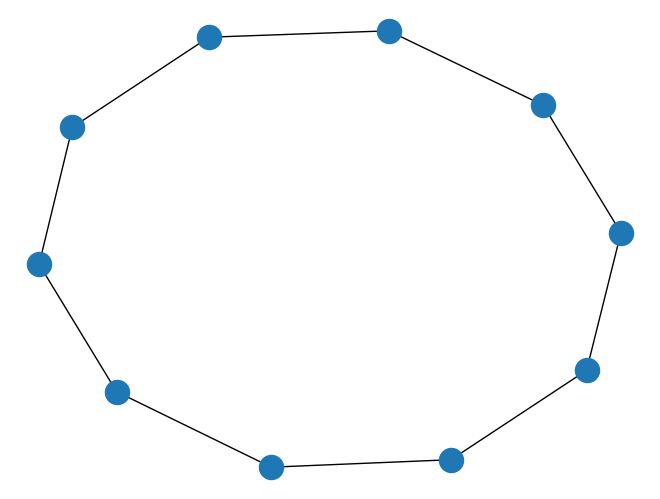

In [3]:
nx.draw(G)

## Original RQAOA and setting up the QAOA properties for the recursive process

Let us first demonstrate how we would solve this problem by making use of the original formulation of RQAOA. As explained in the introduction, this can be done by either selecting `Custom` RQAOA and choosing `steps = 1` or by using `Adaptive` RQAOA and choosing `n_max=1`. Both methods will by default use the original version of RQAOA.

Since RQAOA runs recursively QAOA, we need to set how we want QAOA to run. This is easily done by making use of the RQAOA methods, the workflow is similar to the QAOA one (see the previous tutorial). By calling the corresponding methods we will set all the QAOA properties, e.g.: number of layers, initialization, parametrization, mixer, device, optimizer, etc. 

In [4]:
# Define the RQAOA object (default rqaoa_type='adaptive')
r =  RQAOA()

# Set parameters for RQAOA, in this case we fix the n_max to 1 (default), the final cutoff value to 3
r.set_rqaoa_parameters(n_max=1, n_cutoff=3)

# Set the properties you want - These values are actually the default ones!
r.set_circuit_properties(p=1, param_type='standard', init_type='ramp', mixer_hamiltonian='x')
# Set the classical method used to optimiza over QAOA angles and its properties
r.set_classical_optimizer(method='cobyla', maxiter=200, save_intermediate=False)

In [5]:
# Compile problem instance on RQAOA, to obtain a the OpenQAOA internal description of the problem
r.compile(vc)

## Prepare the input data for the OpenQAOA Job

In [6]:
# Specify a path where to store the QUBO and the QAOA parameters
input_data = create_aws_input_data(r, vc)
save_input_data(input_data,'openqaoa_params.json')

## Send the Job to Braket
Note that this job relies on the OpenQAOA image XXX.dkr.ecr.us-east-1.amazonaws.com/amazon-braket-oq-dev:latest. To build the image from scratch please refer to the readme file in this directory

In [7]:
timestamp = datetime.timestamp(datetime.now())
date_time = datetime.fromtimestamp(timestamp).strftime('%Y%m%d--%H%M%S')
job_name='rqaoa-test-' + date_time

In [8]:
job = AwsQuantumJob.create(
    device="arn:aws:braket:::device/quantum-simulator/amazon/sv1",
    job_name=job_name,
    source_module="./scripts/rqaoa.py",
    image_uri='XXX.dkr.ecr.us-east-1.amazonaws.com/amazon-braket-oq-dev:latest',
    input_data={"input_data": 'openqaoa_params.json'},
    wait_until_complete=True # This frees the console 
    )

Initializing Braket Job: arn:aws:braket:us-east-1:XXX:job/rqaoa-test-20221212--023042
..................................................................................
Job completed!!!!
Code Run Finished
2022-12-12 02:47:50,674 sagemaker-training-toolkit INFO     Waiting for the process to finish and give a return code.
2022-12-12 02:47:50,674 sagemaker-training-toolkit INFO     Done waiting for a return code. Received 0 from exiting process.
2022-12-12 02:47:50,675 sagemaker-training-toolkit INFO     Reporting training SUCCESS


In [9]:
job.state()

'COMPLETED'

In [11]:
res = job.result()

### Analyze the result

We have solved our first problem using RQAOA! Let us now digest the output from the results. First, let's look at the solution returned by RQAOA:

In [12]:
res['rqaoa_result']['solution']

{'0101010101': 5.0}

First, the `res['rqaoa_result']['solution']` dictionary contains to the final solution(s) of the problem, here `0101010101` (the antiferromagnetic solution we expected!), and the associated energy(-ies), here `5.0`. 

But what else can we extract from the logs? The most important data are all the steps used by the RQAOA algorithm. These consists of:
 * The elimination rules
 * The schedule
 * The correlation matrix for each intermediate step

 #### Elimination rules & Intermediate steps

The `res['rqaoa_result']['elimination_rules']` dictionary displays how qubits were eliminated throughout the recursive process. 

Let's use an example to illustrate the notation. For example `{(0, 1): -1.0}` should be read as: qubit `1` was eliminated in favor of qubit `0`, and the correlation between them is negative.

Now let's look at the RQAOA results

In [13]:
res['rqaoa_result']['elimination_rules']

[{'(None, 7)': -1.0},
 {'(3, 4)': -1.0},
 {'(None, 6)': 1.0, '(None, 7)': -1.0},
 {'(None, 4)': -1.0, '(None, 5)': 1.0},
 {'(None, 3)': -1.0}]

Take the first entry, `{(None, 7): -1.0}`. When the label of the remaining qubit reads `None`, the qubit `7` was not eliminated in favor of a remaining one, but was instead fixed to the specified value `-1.0`, resulting from a single-qubit expectation value being the highest ranked.

Since we are also storing all the correlation matrices, we can easily check that this is indeed the case: See how the `7th` qubit on the single features the strongest correlation

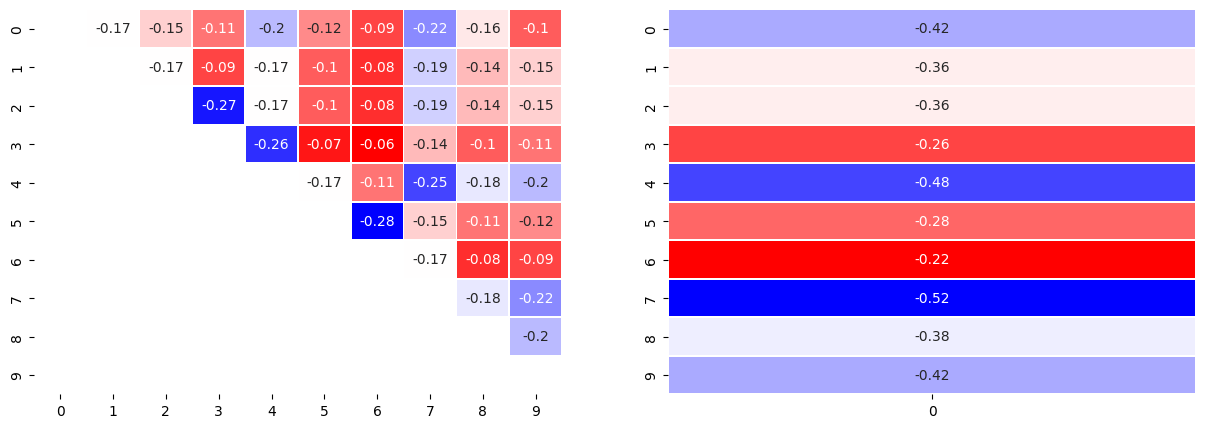

In [19]:
import seaborn as sns
import numpy as np
fig, ax =plt.subplots(1,2, figsize = (15,5)) 
sns.heatmap(np.round(res['rqaoa_result']['intermediate_steps'][0]['corr_matrix'],2), ax=ax[0], cbar=False, annot=True, cmap='bwr', linewidth=0.5,
            mask = np.tril(np.ones_like(res['rqaoa_result']['intermediate_steps'][0]['corr_matrix'], dtype=bool)))

sns.heatmap(np.round(res['rqaoa_result']['intermediate_steps'][0]['exp_vals_z'],2).reshape(10,1), ax=ax[1], cbar=False, annot=True, cmap='bwr', linewidth=0.5)

Finally, we can appreciate the recursive aspect of RQAOA: we started with a 10-qubit problem, and since we set `n_cutoff=3` we will compute correlation matrices and remove qubits until we reach 3 qubits, which is the number of qubits for which we will use classical method to obtain the solution

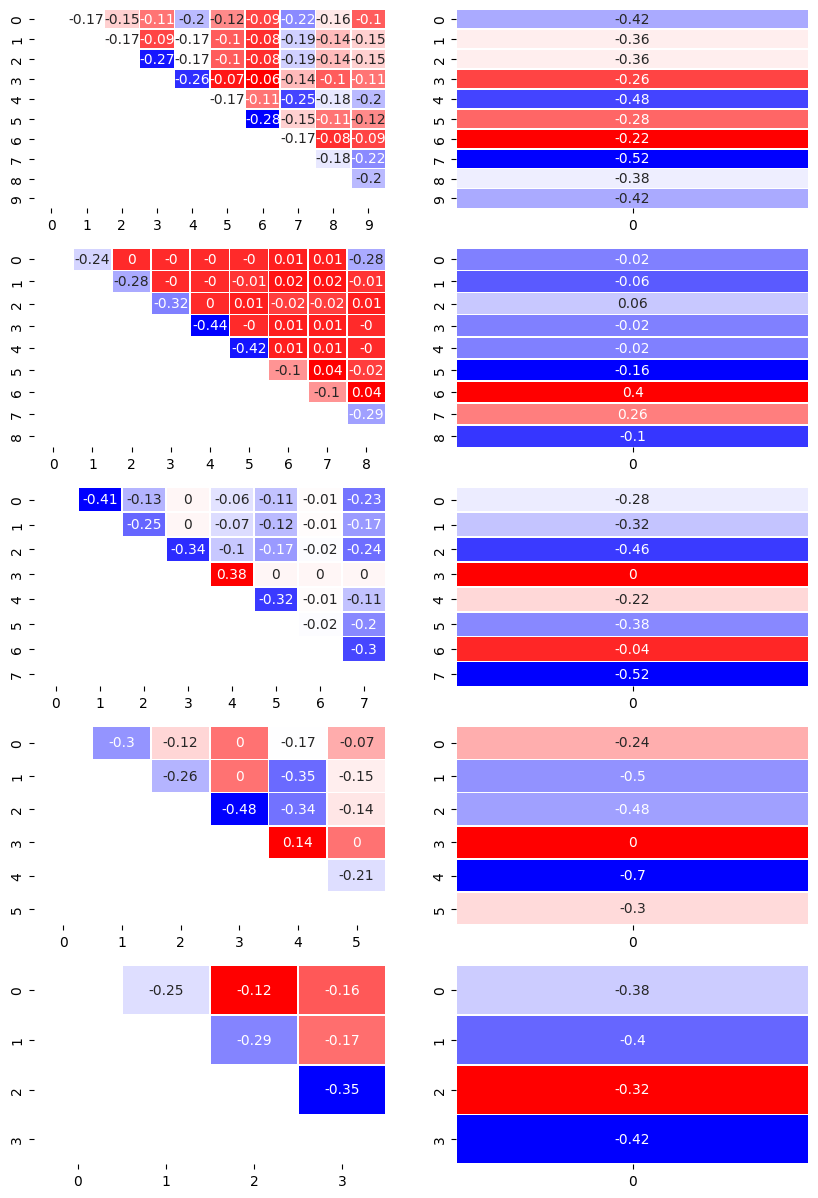

In [20]:
n_steps = len(res['rqaoa_result']['schedule'])
fig, ax = plt.subplots(n_steps,2, figsize = (10,15))

correlation_flow = [res['rqaoa_result']['intermediate_steps'][i]['corr_matrix'] for i in range(n_steps)]

for ind in range(n_steps):
    sns.heatmap(np.round(correlation_flow[ind],2), ax = ax[ind,0], cbar=False, annot=True, cmap=el_map, linewidth=0.5,
                mask = np.tril(np.ones_like(correlation_flow[ind], dtype=bool)))
    
    sns.heatmap(np.round(res['rqaoa_result']['intermediate_steps'][ind]['exp_vals_z'],2).reshape(len(res['rqaoa_result']['intermediate_steps'][ind]['exp_vals_z']),1),
                ax=ax[ind,1], cbar=False, annot=True, cmap ='bwr', linewidth=0.5)